In [78]:
import psycopg2

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint
from collections import OrderedDict

from clickhouse_driver import Client

client = Client('localhost', database="fullspoofdb")

In [79]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

TEST_gigabit_attack_dtls_modified
TEST_gigabit_attack_with_spoof_multi_trial
TEST_gigabit_attack_with_spoof_multi_trial_dtls
TEST_gigabit_attack_without_spoof_multi_trial
TEST_gigabit_attack_without_spoof_multi_trial_dtls
TEST_mbedtls_5
mbedtls_impl_1_client_multi_trial_coap_attacker_no_spoof
mbedtls_impl_1_client_multi_trial_coap_attacker_with_spoof
mbedtls_impl_1_client_multi_trial_dtls_attacker
mbedtls_impl_1_client_multi_trial_100koutbound_dtls

CPU times: user 20.6 ms, sys: 156 µs, total: 20.8 ms
Wall time: 29.7 ms


,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_gigabit_attack_dtls_modified,1000mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,False,True
1,TEST_gigabit_attack_with_spoof_multi_trial,1000mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
2,TEST_gigabit_attack_with_spoof_multi_trial_dtls,1000mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,False,True
3,TEST_gigabit_attack_without_spoof_multi_trial,1000mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
4,TEST_gigabit_attack_without_spoof_multi_trial_dtls,1000mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,False,True
5,TEST_mbedtls_5,100mbps,256,0,1,1,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,False,True
6,mbedtls_impl_1_client_multi_trial_coap_attacker_no_spoof,100mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
7,mbedtls_impl_1_client_multi_trial_coap_attacker_with_spoof,100mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,False,True
8,mbedtls_impl_1_client_multi_trial_dtls_attacker,100mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,False,True
9,mbedtls_impl_1_client_multi_trial_100koutbound_dtls,100mbps,256,0,1,5,120,20,120,120,...,cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,False,True


In [80]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={32, 2, 37, 7, 42, 12, 47, 48, 17, 49, 50, 51, 52, 22, 53, 54, 27}
attacker_dnids={1, 36, 6, 41, 11, 46, 16, 21, 26, 31}
client_node_ids={2, 6, 10, 11, 12, 13, 14, 15, 16}
CPU times: user 6.52 ms, sys: 670 µs, total: 7.18 ms
Wall time: 15.2 ms


In [81]:
%%time

communication_pattern_rates_sql = f"""
WITH all_patterns AS (
  SELECT
    dn.exp_id AS exp_id,
    e.trial AS trial,
    e.observe_timestamp AS observe_timestamp,
    floor(e.observe_timestamp) AS timestamp_bin,
    e.message_marker AS message_marker,
    concat(node_src.node_name, '->', node_dst.node_name) AS communication_pattern,
    m.size_bytes AS size_bytes
  FROM
    event e
    JOIN deployed_node dn ON dn.dnid = e.observer_id
    JOIN message m ON m.message_id = e.message_id
    JOIN node node_src ON node_src.node_id = m.src_id
    JOIN node node_dst ON node_dst.node_id = m.dst_id

), pattern_aggregations AS (
  SELECT
    exp_id,
    trial,
    communication_pattern,
    timestamp_bin,
    SUM(size_bytes) AS sum_bytes,
    COUNT(DISTINCT message_marker) AS num_messages
  FROM
    all_patterns
  GROUP BY
    exp_id, trial, communication_pattern, timestamp_bin
)

SELECT
  *,
  (1e-6 * sum_bytes) AS megabytes_per_second,
  (8 * 1e-6 * sum_bytes) AS megabits_per_second
FROM
  pattern_aggregations
ORDER BY
  timestamp_bin
"""

binned_messages_df = client.query_dataframe(communication_pattern_rates_sql)
binned_messages_df

CPU times: user 114 ms, sys: 37.2 ms, total: 151 ms
Wall time: 36.2 s


,exp_id,trial,communication_pattern,timestamp_bin,sum_bytes,num_messages,megabytes_per_second,megabits_per_second
0,TEST_gigabit_attack_without_spoof_multi_trial_dtls,5,proxy->client1,0.0,5850,15,0.005850,0.046800
1,TEST_gigabit_attack_with_spoof_multi_trial_dtls,1,proxy->originserver,0.0,6012,15,0.006012,0.048096
2,mbedtls_impl_1_client_multi_trial_dtls_attacker,2,proxy->client1,0.0,5070,13,0.005070,0.040560
3,TEST_gigabit_attack_with_spoof_multi_trial_dtls,5,proxy->originserver,0.0,6012,15,0.006012,0.048096
4,mbedtls_impl_1_client_multi_trial_100koutbound_dtls,4,client1->proxy,0.0,4415,16,0.004415,0.035320
...,...,...,...,...,...,...,...,...
18723,TEST_gigabit_attack_without_spoof_multi_trial,5,proxy->client1,99.0,1738,11,0.001738,0.013904
18724,mbedtls_impl_1_client_multi_trial_100koutbound_dtls,2,proxy->originserver,99.0,1624,4,0.001624,0.012992
18725,TEST_gigabit_attack_dtls_modified,3,client1->proxy,99.0,580,4,0.000580,0.004640
18726,TEST_gigabit_attack_dtls_modified,5,proxy->client1,99.0,975,5,0.000975,0.007800


CPU times: user 11.2 s, sys: 125 ms, total: 11.3 s
Wall time: 11.1 s


Text(0.5, 0, 'Time [sec]')

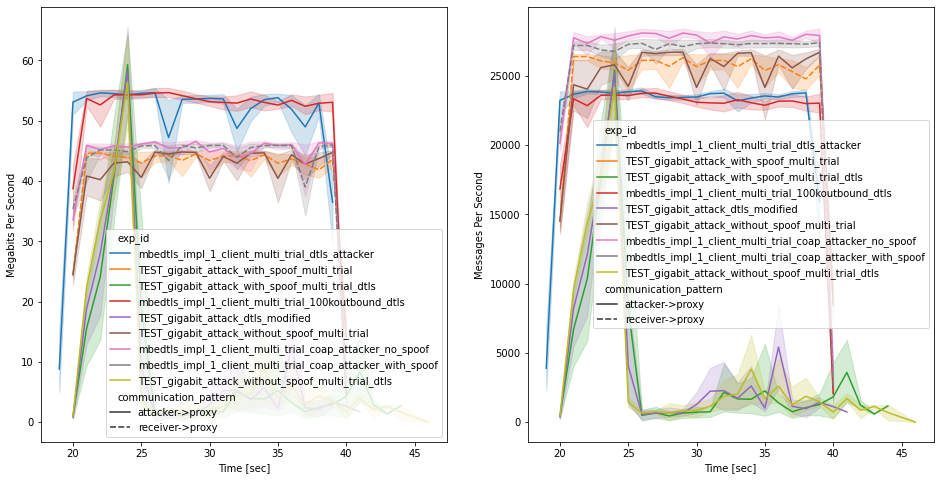

In [87]:
%%time

filtered_binned_messages_df = binned_messages_df[
  (binned_messages_df["communication_pattern"].isin(["attacker->proxy", "receiver->proxy"]))
  & (~(binned_messages_df["exp_id"].isin([
    "TEST_mbedtls_5",
    ])))
]
# filtered_binned_messages_df = binned_messages_df

fig, ax = plt.subplots(1, 2)
g1 = sns.lineplot(
  data=filtered_binned_messages_df,
  x="timestamp_bin",
  y="megabits_per_second",
  style="communication_pattern",
  style_order=["attacker->proxy", "receiver->proxy"],
  hue="exp_id",
  ax=ax[0]
)
ax[0].set_ylabel("Megabits Per Second")
ax[0].set_xlabel("Time [sec]")

g2 = sns.lineplot(
  data=filtered_binned_messages_df,
  x="timestamp_bin",
  y="num_messages",
  style="communication_pattern",
  style_order=["attacker->proxy", "receiver->proxy"],
  hue="exp_id",
  ax=ax[1]
)
ax[1].set_ylabel("Messages Per Second")
ax[1].set_xlabel("Time [sec]")

In [88]:
%%time

_df = (
  filtered_binned_messages_df
  .groupby(by=["exp_id", "communication_pattern"])
  .agg(
    avg_num_messages=("num_messages", "sum"),
    avg_message_size=("sum_bytes", "sum"),
    avg_megabits_per_second=("megabits_per_second", "mean"),
    median_megabits_per_second=("megabits_per_second", "median"),
  )
  .reset_index()
)

_df["avg_message_size"] /= _df["avg_num_messages"]
_df.loc[~(_df["exp_id"].isin(["TEST_mbedtls_5"])), "avg_num_messages"] /= 5
_df["avg_messages_per_second"] = _df["avg_num_messages"]
_df["avg_messages_per_second"] /= 20

print(_df.exp_id)

_df

0                             TEST_gigabit_attack_dtls_modified
1                    TEST_gigabit_attack_with_spoof_multi_trial
2               TEST_gigabit_attack_with_spoof_multi_trial_dtls
3                 TEST_gigabit_attack_without_spoof_multi_trial
4            TEST_gigabit_attack_without_spoof_multi_trial_dtls
5           mbedtls_impl_1_client_multi_trial_100koutbound_dtls
6      mbedtls_impl_1_client_multi_trial_coap_attacker_no_spoof
7    mbedtls_impl_1_client_multi_trial_coap_attacker_with_spoof
8               mbedtls_impl_1_client_multi_trial_dtls_attacker
Name: exp_id, dtype: object
CPU times: user 37.7 ms, sys: 361 µs, total: 38.1 ms
Wall time: 35.2 ms


,exp_id,communication_pattern,avg_num_messages,avg_message_size,avg_megabits_per_second,median_megabits_per_second,avg_messages_per_second
0,TEST_gigabit_attack_dtls_modified,attacker->proxy,89993.8,286.730841,10.425858,2.946864,4499.69
1,TEST_gigabit_attack_with_spoof_multi_trial,receiver->proxy,515235.6,211.369599,41.487673,44.001872,25761.78
2,TEST_gigabit_attack_with_spoof_multi_trial_dtls,attacker->proxy,88671.2,291.421242,9.147140,2.572528,4433.56
3,TEST_gigabit_attack_without_spoof_multi_trial,attacker->proxy,512268.0,209.342244,40.853079,44.367680,25613.40
4,TEST_gigabit_attack_without_spoof_multi_trial_dtls,attacker->proxy,92188.4,291.367599,9.183150,2.903648,4609.42
5,mbedtls_impl_1_client_multi_trial_100koutbound_dtls,attacker->proxy,461006.6,287.402367,50.474053,53.478352,23050.33
6,mbedtls_impl_1_client_multi_trial_coap_attacker_no_spoof,attacker->proxy,551954.6,204.788605,43.060576,46.145616,27597.73
7,mbedtls_impl_1_client_multi_trial_coap_attacker_with_spoof,receiver->proxy,540936.6,206.752315,42.605674,45.565904,27046.83
8,mbedtls_impl_1_client_multi_trial_dtls_attacker,attacker->proxy,468326.4,279.929665,49.942268,53.657656,23416.32


In [89]:
%%time

(
  filtered_binned_messages_df
  .groupby(by=["exp_id", "trial", "communication_pattern"])
  .agg(
    num_messages=("num_messages", "sum"),
    avg_megabits_per_second=("megabits_per_second", "mean"),
    median_megabits_per_second=("megabits_per_second", "median"),
  )
)

CPU times: user 23.1 ms, sys: 2.3 ms, total: 25.4 ms
Wall time: 24.3 ms


num_messages  \
exp_id                                                     trial communication_pattern                 
TEST_gigabit_attack_dtls_modified                          1     attacker->proxy               96209   
                                                           2     attacker->proxy               85929   
                                                           3     attacker->proxy               88616   
                                                           4     attacker->proxy               91512   
                                                           5     attacker->proxy               87703   
TEST_gigabit_attack_with_spoof_multi_trial                 1     receiver->proxy              523154   
                                                           2     receiver->proxy              519953   
                                                           3     receiver->proxy              526067   
                                                           4     receiver->proxy              502274   
                                                           5     receiver->proxy              504730   
TEST_gigabit_attack_with_spoof_multi_trial_dtls            1     attacker->proxy               96462   
                                                           2     attacker->proxy               81448   
                                                           3     attacker->proxy               94091   
                                                           4     attacker->proxy               80689   
                                                           5     attacker->proxy               90666   
TEST_gigabit_attack_without_spoof_multi_trial              1     attacker->proxy              513509   
                                                           2     attacker->proxy              499378   
                                                           3     attacker->proxy              527975   
                                                           4     attacker->proxy              513558   
                                                           5     attacker->proxy              506920   
TEST_gigabit_attack_without_spoof_multi_trial_dtls         1     attacker->proxy               96468   
                                                           2     attacker->proxy               89899   
                                                           3     attacker->proxy               97816   
                                                           4     attacker->proxy               90635   
                                                           5     attacker->proxy               86124   
mbedtls_impl_1_client_multi_trial_100koutbound_dtls        1     attacker->proxy              445239   
                                                           2     attacker->proxy              465879   
                                                           3     attacker->proxy              454310   
                                                           4     attacker->proxy              461996   
                                                           5     attacker->proxy              477609   
mbedtls_impl_1_client_multi_trial_coap_attacker_no_spoof   1     attacker->proxy              551400   
                                                           2     attacker->proxy              548269   
                                                           3     attacker->proxy              548667   
                                                           4     attacker->proxy              559804   
                                                           5     attacker->proxy              551633   
mbedtls_impl_1_client_multi_trial_coap_attacker_with_spoof 1     receiver->proxy              548573   
                                                           2     receiver->proxy              546070   
                                

In [90]:
%%time

client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' '' 'bad_gateway']
CPU times: user 309 ms, sys: 86.5 ms, total: 395 ms
Wall time: 855 ms


,exp_id,trial,observer_id,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,successful_message
0,TEST_gigabit_attack_dtls_modified,1,client1,1,content,0.000000,0.152304,0.000000,0.000000,0.152304,0.152304,152.303934,152.303934,1,1,0,True
1,TEST_gigabit_attack_dtls_modified,1,client1,2,content,0.166265,0.224834,0.166265,0.166265,0.224834,0.224834,58.568954,58.568954,1,1,0,True
2,TEST_gigabit_attack_dtls_modified,1,client1,3,content,0.228564,0.285297,0.228564,0.228564,0.285297,0.285297,56.732893,56.732893,1,1,0,True
3,TEST_gigabit_attack_dtls_modified,1,client1,4,content,0.289563,0.346295,0.289563,0.289563,0.346295,0.346295,56.732178,56.732178,1,1,0,True
4,TEST_gigabit_attack_dtls_modified,1,client1,5,content,0.350111,0.406644,0.350111,0.350111,0.406644,0.406644,56.533098,56.533098,1,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63599,mbedtls_impl_1_client_multi_trial_dtls_attacker,5,client1,459455,content,97.840832,97.893960,97.840832,97.840832,97.893960,97.893960,53.128004,53.128004,1,1,0,True
63600,mbedtls_impl_1_client_multi_trial_dtls_attacker,5,client1,459456,content,97.895352,97.948385,97.895352,97.895352,97.948385,97.948385,53.032875,53.032875,1,1,0,True
63601,mbedtls_impl_1_client_multi_trial_dtls_attacker,5,client1,459457,content,97.949596,98.002750,97.949596,97.949596,98.002750,98.002750,53.153992,53.153992,1,1,0,True
63602,mbedtls_impl_1_client_multi_trial_dtls_attacker,5,client1,459458,content,98.003948,98.057027,98.003948,98.003948,98.057027,98.057027,53.079128,53.079128,1,1,0,True


In [92]:
%%time

(
  message_rtt_df.groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    avg_rtt_ms_first_transmission=("rtt_ms_first_transmission", "mean"),
    avg_rtt_ms_last_transmission=("rtt_ms_last_transmission", "mean"),
    num_unique_messages=("message_marker", "nunique"),
    num_messages=("message_marker", "count"),
    num_successful_messages=("successful_message", "sum"),
    num_send_messages=("num_send_observations", "sum"),
    num_recv_messages=("num_recv_observations", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
  )
  .tail(20)
)

CPU times: user 70.4 ms, sys: 413 µs, total: 70.8 ms
Wall time: 69 ms


avg_rtt_ms_first_transmission  \
exp_id                                                     trial observer_id                                  
mbedtls_impl_1_client_multi_trial_100koutbound_dtls        1     client1                          70.995668   
                                                           2     client1                          71.245139   
                                                           3     client1                          71.243904   
                                                           4     client1                          71.287427   
                                                           5     client1                          71.298152   
mbedtls_impl_1_client_multi_trial_coap_attacker_no_spoof   1     client1                          72.122161   
                                                           2     client1                          71.861642   
                                                           3     client1                          71.620159   
                                                           4     client1                          71.647015   
                                                           5     client1                          71.834731   
mbedtls_impl_1_client_multi_trial_coap_attacker_with_spoof 1     client1                          72.054740   
                                                           2     client1                          71.821324   
                                                           3     client1                          72.015240   
                                                           4     client1                          71.919471   
                                                           5     client1                          71.834368   
mbedtls_impl_1_client_multi_trial_dtls_attacker            1     client1                          79.236718   
                                                           2     client1                          60.761158   
                                                           3     client1                          72.450681   
                                                           4     client1                          72.716373   
                                                           5     client1                          72.479371   

                                                                              avg_rtt_ms_last_transmission  \
exp_id                                                     trial observer_id                                 
mbedtls_impl_1_client_multi_trial_100koutbound_dtls        1     client1                         63.772906   
                                                           2     client1                         59.269584   
                                                           3     client1                         62.791016   
                                                           4     client1                         61.210636   
                                                           5     client1                         61.649937   
mbedtls_impl_1_client_multi_trial_coap_attacker_no_spoof   1     client1                         60.585888   
                                                           2     client1                         63.328231   
                                                           3     client1                         63.224090   
                                                           4     client1                         62.680934   
                                                           5     client1                         62.818235   
mbedtls_impl_1_client_multi_trial_coap_attacker_with_spoof 1     client1                         64.002024   
                                                           2     client1                         63.148616   
                                                           3     client1                       

In [95]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df

CPU times: user 12.1 ms, sys: 7.25 ms, total: 19.3 ms
Wall time: 96.9 ms


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value
0,TEST_gigabit_attack_dtls_modified,1,originserver,cpu_utilization,3.021667,0.4,20.7
1,TEST_gigabit_attack_dtls_modified,1,proxy,cpu_utilization,6.761667,0.4,89.4
2,TEST_gigabit_attack_dtls_modified,1,originserver,memory_utilization,249.030829,238.0,263.0
3,TEST_gigabit_attack_dtls_modified,1,proxy,memory_utilization,833.723404,239.0,1046.0
4,TEST_gigabit_attack_dtls_modified,2,originserver,cpu_utilization,2.672500,0.4,20.9
...,...,...,...,...,...,...,...
179,mbedtls_impl_1_client_multi_trial_dtls_attacker,4,proxy,memory_utilization,4017.536965,459.0,5737.0
180,mbedtls_impl_1_client_multi_trial_dtls_attacker,5,originserver,cpu_utilization,1.802500,0.2,10.3
181,mbedtls_impl_1_client_multi_trial_dtls_attacker,5,proxy,cpu_utilization,6.478992,0.2,63.3
182,mbedtls_impl_1_client_multi_trial_dtls_attacker,5,originserver,memory_utilization,479.233918,457.0,508.0


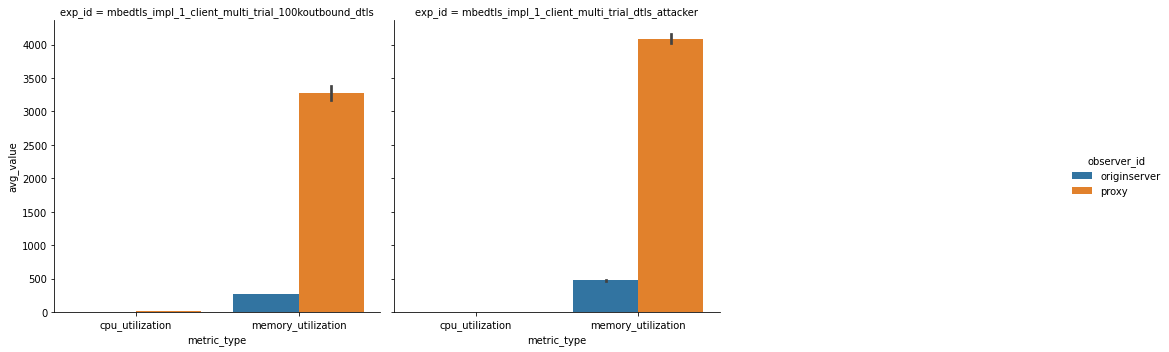

CPU times: user 1.05 s, sys: 107 ms, total: 1.15 s
Wall time: 833 ms


In [106]:
%%time


filtered_metric_df = metric_df[metric_df["exp_id"].isin([
  "mbedtls_impl_1_client_multi_trial_dtls_attacker",
  "mbedtls_impl_1_client_multi_trial_100koutbound_dtls",
])]

g = sns.catplot(
  kind="bar",
  data=filtered_metric_df,
  x="metric_type",
  y="avg_value",
  hue="observer_id",
  col="exp_id",
  col_wrap=3,
)

plt.show()

In [93]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

# Filter out outlier experiments and trials
client_rps_df = client_rps_df[
  ((client_rps_df["exp_id"] == "TEST_mbedtls_5") & (client_rps_df["trial"] == 1))
  & ((client_rps_df["exp_id"] == "mbedtls_impl_1_client_multi_trial_dtls_attacker") & (client_rps_df["trial"] == 1))
  & ((client_rps_df["exp_id"] == "mbedtls_impl_1_client_multi_trial_dtls_attacker") & (client_rps_df["trial"] == 2))
]
client_rps_df

CPU times: user 379 ms, sys: 313 µs, total: 380 ms
Wall time: 375 ms


,exp_id,trial,observer_id,num_messages,num_successful_messages,mean_rps,num_retransmissions,stddev_rtt_ms,min_rtt_ms,median_rtt_ms,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker


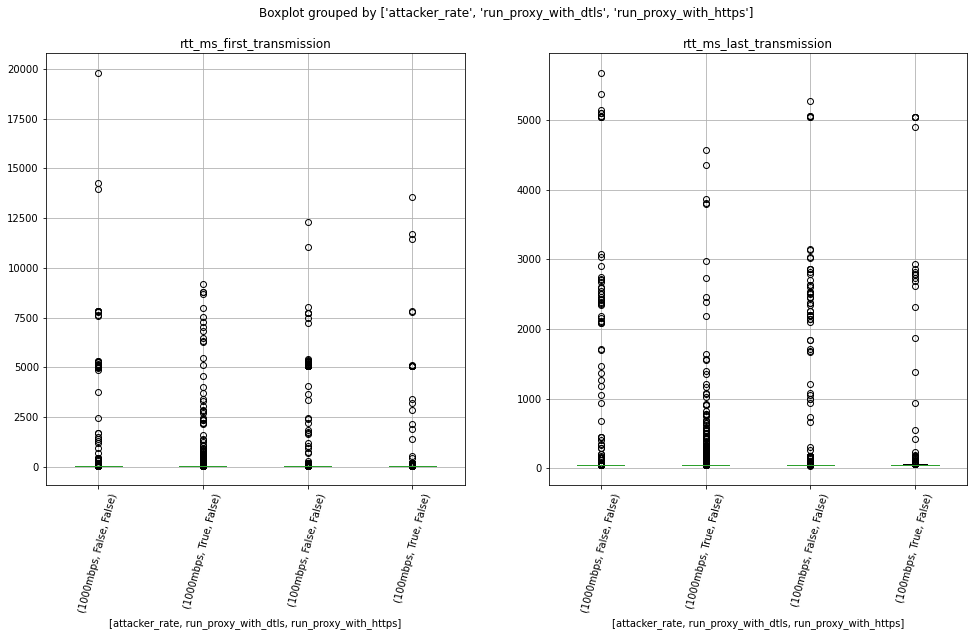

average_rps
attacker_rate run_proxy_with_dtls run_proxy_with_https             
1000mbps      False               False                   70.938426
              True                False                   61.229468
100mbps       False               False                   71.872302
              True                False                   71.954454

In [138]:
df = message_rtt_df
param_comparison_scope = ["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "rot": 75,
  "by": param_comparison_scope,
}

plots = ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
_, axes = plt.subplots(1, len(plots))
for i, p in enumerate(plots):
  df.boxplot(p, ax=axes[i], **plot_args)

plt.show()

(
  message_rtt_df
  .groupby(by=["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"])
  .agg(
    average_rps=("rtt_ms_first_transmission", "mean")
  )
)

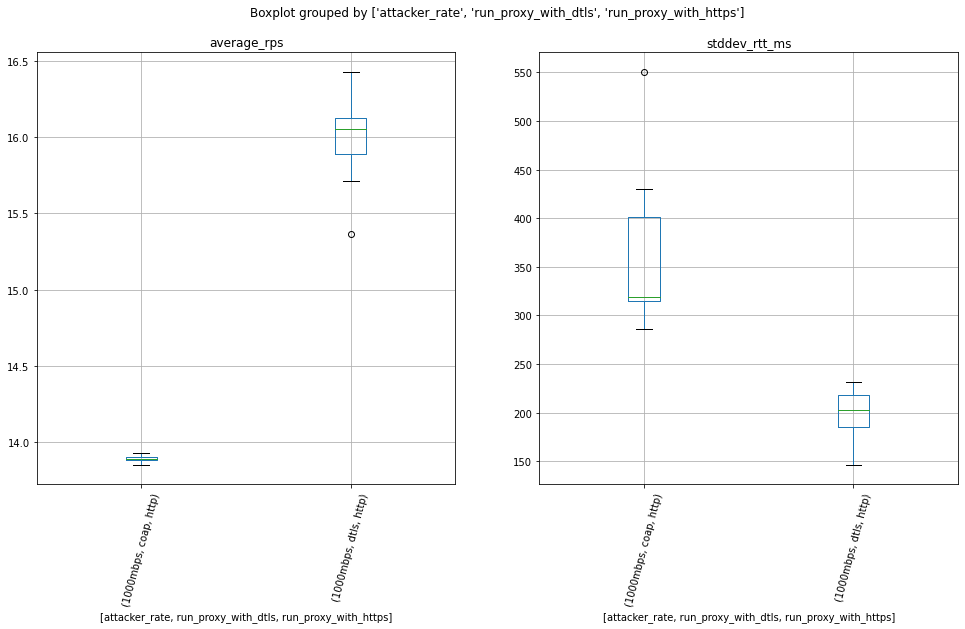

In [43]:
df = client_rps_df
param_comparison_scope = ["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "rot": 75,
  "by": param_comparison_scope,
}

plots = ["average_rps", "stddev_rtt_ms"]
_, axes = plt.subplots(1, len(plots))
for i, p in enumerate(plots):
  df.boxplot(p, ax=axes[i], **plot_args)

plt.show()

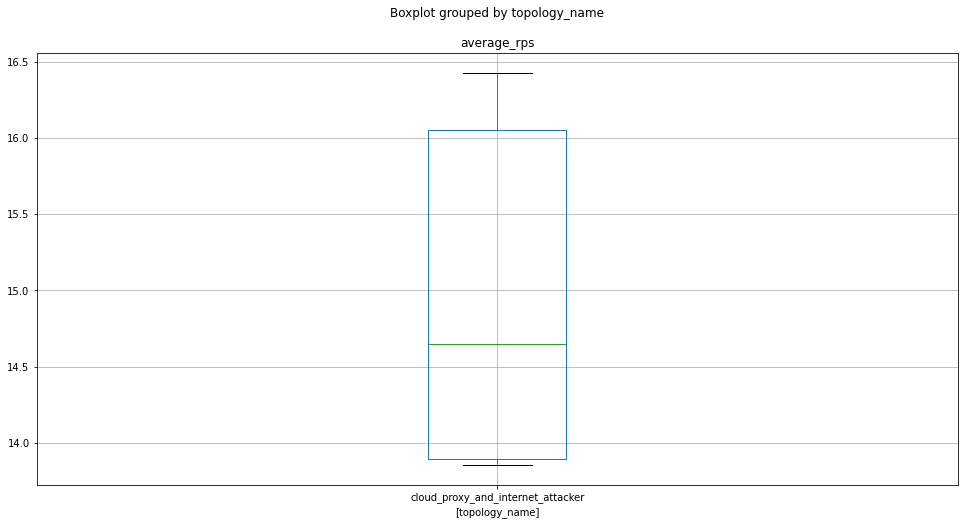

In [44]:
param_comparison_scope = ["topology_name"]

ax = None
ax = df.boxplot("average_rps", by=param_comparison_scope, ax=ax)
plt.show()

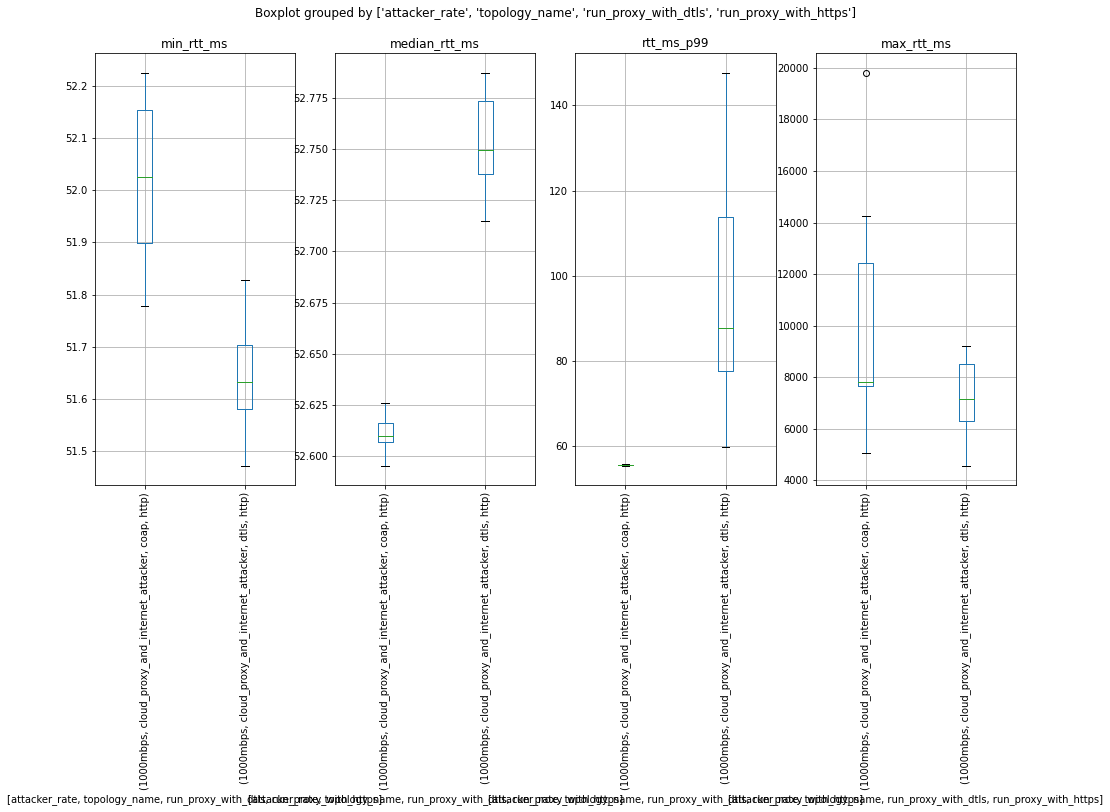

In [46]:
param_comparison_scope = ["attacker_rate", "topology_name", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "by": param_comparison_scope,
  "rot": 90,
}

_, axes = plt.subplots(1, 4)

df.boxplot("min_rtt_ms", ax=axes[0], **plot_args)
df.boxplot("median_rtt_ms", ax=axes[1], **plot_args)
df.boxplot("rtt_ms_p99", ax=axes[2], **plot_args)
df.boxplot("max_rtt_ms", ax=axes[3], **plot_args)

plt.show()